In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Calculate next-generation matrix for three age-classes.

def giveContactMatrix():

    eigenvalues, eigenvectors = np.linalg.eig(demography*contactMatrix)
    dominantEigenvalue = eigenvalues[0]
    
    #Scale contact matrix such that dominant eigenvalue of q*R is 1.
    return contactMatrix/dominantEigenvalue

In [3]:
#Parameter settings.

R0 = 1.4

nu1 = 2.5                                    #Latent to infectious rate.
nu2 = 1.1                                    #Recovery rate.    
beta = nu2*R0/2.0                            #Transmitability parameter.
    
N = 1000000.0                                #Population size.
endTime = 10000                                #Number of days to be calculated.
eps = 0.00001                                #Initial fraction infecteds.


contactMatrix = np.array([[9,3,1],[3,3,2],[1,2,2]])      #Contact matrix between young, middle, and old.
demography = np.array([1/8.,5/8.,2/8.])

states = 7
groups = len(demography)                     #Number of age groups.
cij = giveContactMatrix()
    

In [4]:
#SIR-model for one season.
#Includes age structure and vaccinated population.

#Input s0 and p0 are as fraction of the age group.
#Outputs are in fraction of total population.

from scipy.integrate import odeint

def SEEIIR(Vr,s0,p0):

    if N*s0[0] < 100:
        print 'Warning: N to small'
    
    def ForceInfection(Y,i):
            
        infecteds = Y[:,4]+Y[:,5]
        force = (beta/N)*cij[i,:]*infecteds

        return sum(force)
        
    def derivative(y,t):

        Y = y.reshape((groups,states))
               
        dydt = []
        
        #Run over the age groups.
        for i,x in enumerate(Y):
            #S=x[0], P=x[1], E1=x[2], E2=x[3], I1=x[4], I2=x[5], R=x[6]
            
            force = ForceInfection(Y,i)

            dSdt = -force*x[0]
            dPdt = -(1-Vr)*force*x[1]
        
            dE1dt = force*(x[0]+(1-Vr)*x[1]) - nu1*x[2]
            dE2dt = nu1*x[2] - nu1*x[3]
        
            dI1dt = nu1*x[3] - nu2*x[4]
            dI2dt = nu2*x[4] - nu2*x[5]
        
            dRdt = nu2*x[5]
        
            dydt.extend([dSdt, dPdt, dE1dt, dE2dt, dI1dt, dI2dt, dRdt])
            
        return dydt
    
    #Note: adding Jacobian to ODE solver makes integrator slower.
    def Jacobian(y,t):
        
        Y = y.reshape((groups,states))
        
        force = ForceInfection(Y,0)
        
        J = np.zeros((groups*states, groups*states))
        
        J[0,0] = -force
        J[3,0] = -(beta/N)*y[0]
        J[4,0] = -(beta/N)*y[0]
        
        J[1,0] = force
        J[1,1] = -nu1
        J[3,1] = -(beta/N)*y[0]
        J[4,1] = -(beta/N)*y[0]

        J[2,1] = nu1
        J[2,2] = -nu1
        
        J[3,2] = nu1
        J[3,3] = -nu2
        
        J[4,3] = nu2
        J[4,4] = -nu2
        
        J[5,4] = nu2
        
        return J

    
    time = np.linspace(0.0,200,200)
    
    yinit = np.concatenate( [[ (s-2*eps)*f*N, p*f*N, 0.0, 0.0, eps*f*N, eps*f*N, (1-(s+p))*f*N] 
                             for s,p,f in zip(s0,p0,demography)] )

    y = odeint(derivative,yinit,time)#,Dfun=Jacobian)
    
    while sum(abs(y[-1]-y[-2])) > 0.001*N and time[-1] < endTime:
        dtime = np.linspace(0.0,100,100)
        ynew = odeint(derivative,y[-1],dtime)
        
        y = np.concatenate([y,ynew])
    
    time = np.linspace(0.0,len(y),len(y))
    
    return time, y/N

In [36]:
#Function gives the attack rate for all age groups (and for s and p), as fraction of these age groups.
def giveAttackrate(y):
    #Take difference between start and end of the epidemic.
    diffy = y[0]-y[-1]
    Y = diffy.reshape((groups,states))
    
    #Calculate total reduction in susceptibility (i.e. the attack rate).
    return Y[:,0]/demography,Y[:,1]/demography
    
def giveTotalIncindence(y):
    return [np.sum(x.reshape((groups,states))[:,4:6]) for x in y]
    
def giveEpidemicPeak(y):
    peak = max(giveTotalIncindence(y))
    if peak <= 2*eps: peak = 0.0
    return peak


In [37]:
1/1.4

0.7142857142857143

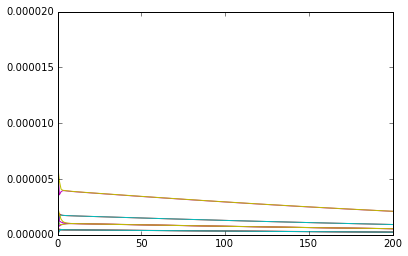

In [38]:
sIn = 0.71*np.ones(groups)
pIn = np.zeros(groups)

time, proportions = SEEIIR(0.5,sIn,pIn)

plot(time,proportions)

ylim([0,0.00002])
show()

In [39]:
print giveAttackrate(proportions)
print giveEpidemicPeak(proportions)

(array([ 0.00135711,  0.00104318,  0.00067489]), array([ 0.,  0.,  0.]))
0.0


In [8]:
def giveNextSusceptibility(parameters,gamma,sIn,pIn):
    R0 = parameters['R0']
    Vc = parameters['Vc']
    Ve = parameters['Ve']
    Vr = parameters['Vr']

    #First vaccination, then epidemic, at last waning.
    s1 = (1.0-Vc*Ve)*sIn
    p1 = pIn + Vc*Ve*sIn
    
    time, proportions = SEEIIR(R0,Vr,s1,p1)
    
    peak = giveEpidemicPeak(proportions)
    zS, zP = giveAttackrate(proportions)
    
    s2 = s1 - zS
    p2 = p1 - zP
    
    sOut = np.ones(groups) - gamma*( np.ones(groups) - s2 )
    pOut = gamma*p2
    
    #Output: final size as fraction of susceptible/vaccinated population.
    #        susceptibilities as fraction of age group.
    return (zS/s1,zP/p1),(sOut,pOut), peak

In [9]:
#Timeseries functions.
import random as rnd

def calculateTimeseries(parameters,years,mode):
    
    #Add burn-in period.
    years = range(0,years+50)
    
    #Initialise output vectors (s: susceptibles, p: partly immunes).
    timeseriesSusc = dict([('s',[np.ones(groups)]),('p',[np.zeros(groups)])])      #Fraction susceptibles at start of season.
    timeseriesFinal = dict([('s',[np.zeros(groups)]),('p',[np.zeros(groups)])])    #Fraction infected during seasonal epidemic.
    peaks = []
    
    for year in years:
        
        if mode == 'Deterministic':
            gamma = parameters['gamma']
        elif mode == 'Stochastic':
            gamma = rnd.betavariate(5,2)
        else:
            print 'Wrong mode. Set mode to Deterministic or Stochastic.'
        
        s, p = timeseriesSusc['s'][-1], timeseriesSusc['p'][-1]
        
        
        finalSize, susceptibility, peak = giveNextSusceptibility(parameters,gamma,s,p)
        
        timeseriesSusc['s'] += [ susceptibility[0] ]
        timeseriesSusc['p'] += [ susceptibility[1] ]
        
        timeseriesFinal['s'] += [ finalSize[0] ]
        timeseriesFinal['p'] += [ finalSize[1] ]
        
        peaks += [ peak ]
   
    #Remove burn-in period.
    timeseriesSusc['s'] = np.array(timeseriesSusc['s'][51:])
    timeseriesSusc['p'] = np.array(timeseriesSusc['p'][51:])
    
    timeseriesFinal['s'] = np.array(timeseriesFinal['s'][51:])
    timeseriesFinal['p'] = np.array(timeseriesFinal['p'][51:])
        
    return timeseriesSusc, timeseriesFinal, peaks

In [10]:
myParameters = dict([
['R0', 1.4],            #Basic reproduction number.
['gamma', 5/7.],       #Waning immunity rate. Mean beta distribution = alpha/(alpha+beta) = 10/12
['Vc', 0.00001],            #Vaccine coverage.
['Ve', 1.0],            #Vaccine efficiency.
['Vr', 0.5]])           #Vaccine resistance.


In [11]:
import time

start = time.time()

x,y,peaks = calculateTimeseries(myParameters,100,'Stochastic')

end = time.time()

print end-start

19.7140309811
